In [1]:
import os, sys, glob
from datetime import datetime
sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')

from mi.instrument.kut.ek60.ooicore.zplsc_b import *
from concat_raw import *

data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
fname1 = glob.glob(os.path.join(data_path,'OOI-D20150910-T*.raw'))
fname2 = glob.glob(os.path.join(data_path,'OOI-D20170910-T*.raw'))
fname1 = fname1[0]
fname2 = fname2[0]

In [2]:
%matplotlib inline

Load data:

In [3]:
particle_data1, data_times1, power_data_dict1, freq1, bin_size1, config_header1, config_transducer1 = parse_echogram_file(fname1)

2017-09-17 17:54:26,508 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150910-T000000.raw'


In [4]:
particle_data2, data_times2, power_data_dict2, freq2, bin_size2, config_header2, config_transducer2 = parse_echogram_file(fname2)

2017-09-17 17:54:29,049 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20170910-T000000.raw'


### Function for noise estimation

In [6]:
def get_noise(power_data,depth_bin_size,ping_bin_range,depth_bin_range,tvgCorrectionFactor=2):
    '''
    INPUT:
        ping_bin_range        average over M pings
        depth_bin_range       average over depth_bin_range [m]
        tvgCorrectionFactor   default (=2) is to apply TVG correction with offset of 2 samples
                              note this factor is important in TVG compensation
                              and therefore in how power_bin is obtained as well
    OUTPUT:
        minimum value for bins of averaged ping
    '''
    N = int(np.floor(depth_bin_range/depth_bin_size))
    
    # Average uncompensated power over M pings and N depth bins
    depth_bin_num = int(np.floor((power_data.shape[0]-tvgCorrectionFactor)/N))
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    power_bin = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N)+N*iD+tvgCorrectionFactor  # match the 2-sample offset
            ping_idx = np.arange(ping_bin_range)+ping_bin_range*iP
            power_bin[iD,iP] = np.mean(10**(power_data[np.ix_(depth_idx,ping_idx)]/10))

    # Noise = minimum value for each averaged ping
    return np.min(power_bin,0)

### Function for noise removal and TVG + absorption compensation

In [7]:
def remove_noise(power_data,cal,noise_est,ping_bin_range=40,tvg_correction_factor=2):
    '''
    Function for noise removal and TVG + absorption compensation
    fn      sequence number of that particular freq in power_data
            corresponds to index fn-1 in cal_params
    tvg_correction_factor   default(=2) for converting power_data to Sv
    '''

    # Get cal params
    f = cal['frequency']
    c = cal['soundvelocity']
    t = cal['sampleinterval']
    alpha = cal['absorptioncoefficient']
    G = cal['gain']
    phi = cal['equivalentbeamangle']
    pt = cal['transmitpower']
    tau = cal['pulselength']

    # key derived params
    dR = c*t/2   # sample thickness
    wvlen = c/f  # wavelength

    # Calc gains
    CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

    # calculate Sa Correction
    idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
    Sac = 2 * cal['sacorrectiontable'][idx]

    # Get TVG
    range_vec = np.arange(power_data.shape[0]) * dR
    rangeCorrected = range_vec - (tvg_correction_factor * dR)
    rangeCorrected[rangeCorrected<0] = 0

    TVG = np.empty(rangeCorrected.shape)
    TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
    TVG[rangeCorrected==0] = 0

    # Get absorption
    ABS = 2*alpha*rangeCorrected

    # Compensate measurement for noise and corrected for transmission loss
    # also estimate Sv_noise component for subsequent SNR check

    # Method 1: subtract before compensate
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    Sv_corr1 = np.empty(power_data.shape)   # log domain corrected Sv
    Sv_noise = np.empty(power_data.shape)  # Sv_noise
    for iP in range(ping_bin_num):
        ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
        subtract1 = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
        tmp1 = np.empty(subtract1.shape)
        tmp1[subtract1>0] = 10*np.log10(subtract1[subtract1>0])
        tmp1[subtract1<=0] = -999
        tmp1 = (tmp1.T +TVG+ABS).T
        Sv_corr1[:,ping_idx] = tmp1
        Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG +ABS]*ping_bin_range).T

    # Method 2: compensate before subtract
    Sv_raw = (power_data.T+TVG+ABS).T  # compensation first (log domain)
    subtract2 = 10**(Sv_raw/10)-10**(Sv_noise/10)
    tmp2 = np.empty(subtract2.shape)
    tmp2[subtract2>0] = 10*np.log10(subtract2[subtract2>0])
    tmp2[subtract2<=0] = -999
    Sv_corr2 = tmp2
    
    # Output
    return Sv_raw,Sv_noise,Sv_corr1,Sv_corr2
    

## Use 20170910 data to test ways to threshold data

In [9]:
power_data = power_data_dict2   # 20170910 data
cal_params = get_cal_params(power_data,particle_data1,config_header1,config_transducer1)
ping_bin_range=40
depth_bin_range=10
tvg_correction_factor=2
fn = 1
noise_est_120 = get_noise(power_data[fn],bin_size1,ping_bin_range,depth_bin_range)
Sv_raw_120,Sv_noise_120,Sv_corr_120,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_120,ping_bin_range,tvg_correction_factor)
fn = 2
noise_est_38 = get_noise(power_data[fn],bin_size1,ping_bin_range,depth_bin_range)
Sv_raw_38,Sv_noise_38,Sv_corr_38,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_38,ping_bin_range,tvg_correction_factor)
fn = 3
noise_est_200 = get_noise(power_data[fn],bin_size1,ping_bin_range,depth_bin_range)
Sv_raw_200,Sv_noise_200,Sv_corr_200,_ = remove_noise(power_data[fn],cal_params[fn-1],noise_est_200,ping_bin_range,tvg_correction_factor)

### Data from 3 frequencies

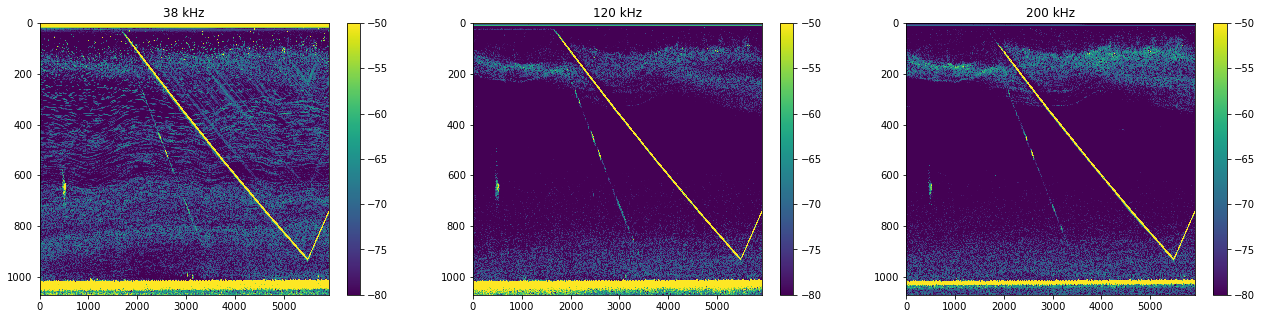

In [12]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_raw_38,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('38 kHz')
im1 = ax1.imshow(Sv_raw_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('120 kHz')
im2 = ax2.imshow(Sv_raw_200,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('200 kHz')

## Logerwill & Wilson 2004 method

### Function to get mean MVBS after thresholding data

In [13]:
def mean_MVBS_th(Sv,th,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS after thresholding Sv
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    Sv_cp = np.copy(Sv)
    Sv_cp[Sv_cp<=th] = np.nan  # set all values below th to np.nan
    
    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv_cp.shape[0]/N))
    ping_bin_num = int(np.floor(Sv_cp.shape[1]/ping_bin_range))
    MVBS = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N) + N*iD
            ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
            MVBS[iD,iP] = 10*np.log10( np.nanmean(10**(Sv_cp[np.ix_(depth_idx,ping_idx)]/10)) )

    # Set NaN pixels to -999
    #MVBS[np.isnan(MVBS)] = -999
            
    return MVBS

In [17]:
ping_bin_range = 100
depth_bin_range = 5
depth_bin_size = bin_size2
Sv = Sv_corr_120
th = -79

Sv_cp = np.copy(Sv)
Sv_cp[Sv_cp<=th] = np.nan  # set all values below th to np.nan

N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins

# Average Sv over M pings and N depth bins
depth_bin_num = int(np.floor(Sv_cp.shape[0]/N))
ping_bin_num = int(np.floor(Sv_cp.shape[1]/ping_bin_range))
MVBS = np.empty([depth_bin_num,ping_bin_num])
for iD in range(depth_bin_num):
    for iP in range(ping_bin_num):
        depth_idx = np.arange(N) + N*iD
        ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
        MVBS[iD,iP] = 10*np.log10( np.nanmean(10**(Sv_cp[np.ix_(depth_idx,ping_idx)]/10)) )

# Set NaN pixels to -999
#MVBS[np.isnan(MVBS)] = -999

#return MVBS

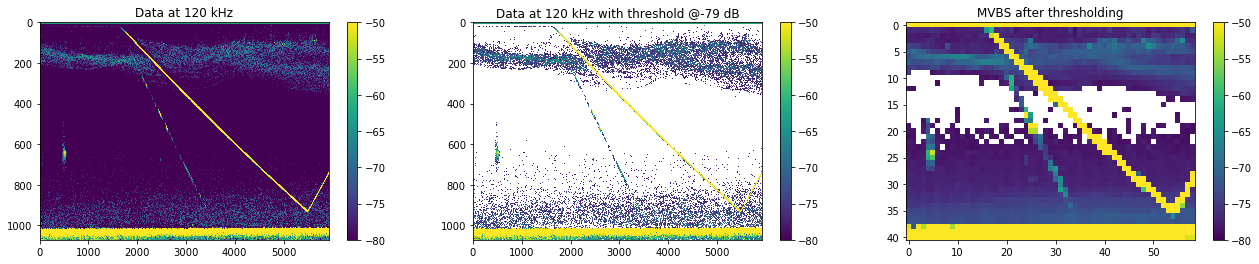

In [81]:
fig,ax = plt.subplots(1,3,figsize=(22,4))
im0 = ax[0].imshow(Sv_corr_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0])
ax[0].set_title('Data at 120 kHz')
im1 = ax[1].imshow(Sv_cp,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[1])
ax[1].set_title('Data at 120 kHz with threshold @-79 dB')
im2 = ax[2].imshow(MVBS,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[2])
ax[2].set_title('MVBS after thresholding')

In [45]:
th_all = range(-91,-37,6)   # th = [-91, -85, -79, -73, -67, -61, -55, -49, -43]
ping_bin_range = 100
depth_bin_range = 5
depth_bin_size = bin_size2
N = int(np.floor(depth_bin_range/bin_size1))  # total number of depth bins
depth_bin_num = int(np.floor(Sv_corr_120.shape[0]/N))
ping_bin_num = int(np.floor(Sv_corr_120.shape[1]/ping_bin_range))
MVBS_min = np.empty((depth_bin_num,len(th_all)))
for (iTH,th) in zip(range(len(th_all)),th_all):
    tmp = mean_MVBS_th(Sv_corr_120,th,depth_bin_size,ping_bin_range,depth_bin_range)
    MVBS_min[:,iTH] = [np.nanmin(tmp[nn,:]) for nn in range(tmp.shape[0]) ]

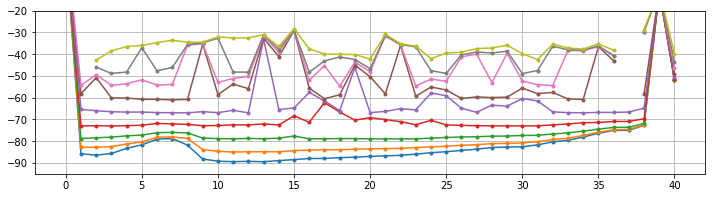

In [51]:
plt.figure(figsize=(12,3))
plt.plot(MVBS_min,'.-')
plt.ylim([-95,-20])
plt.grid()

Based on the above figure should select Sv threshold = -73 dB.

What if increase the number of pings to be averaged to 500 pings?

In [57]:
th_all = range(-91,-37,6)   # th = [-91, -85, -79, -73, -67, -61, -55, -49, -43]
ping_bin_range = 500
depth_bin_range = 5
depth_bin_size = bin_size2
N = int(np.floor(depth_bin_range/bin_size1))  # total number of depth bins
depth_bin_num = int(np.floor(Sv_corr_120.shape[0]/N))
ping_bin_num = int(np.floor(Sv_corr_120.shape[1]/ping_bin_range))
MVBS_min = np.empty((depth_bin_num,len(th_all)))
for (iTH,th) in zip(range(len(th_all)),th_all):
    tmp = mean_MVBS_th(Sv_corr_120,th,depth_bin_size,ping_bin_range,depth_bin_range)
    MVBS_min[:,iTH] = [np.nanmin(tmp[nn,:]) for nn in range(tmp.shape[0]) ]

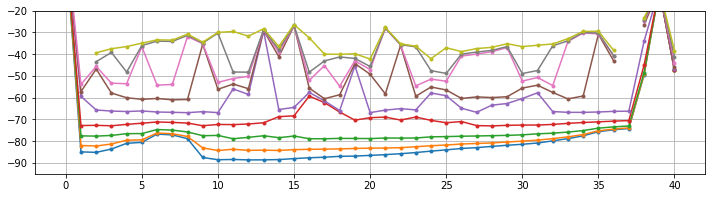

In [58]:
plt.figure(figsize=(12,3))
plt.plot(MVBS_min,'.-')
plt.ylim([-95,-20])
plt.grid()

Based on the above figure should still select Sv threshold = -73 dB.

## Thresholding solely based on SNR

In [99]:
SNR_th = 10
SNR = Sv_corr_120-Sv_noise_120
Sv_corr_120_SNR = np.copy(Sv_corr_120)
Sv_corr_120_SNR[SNR<SNR_th] = np.nan

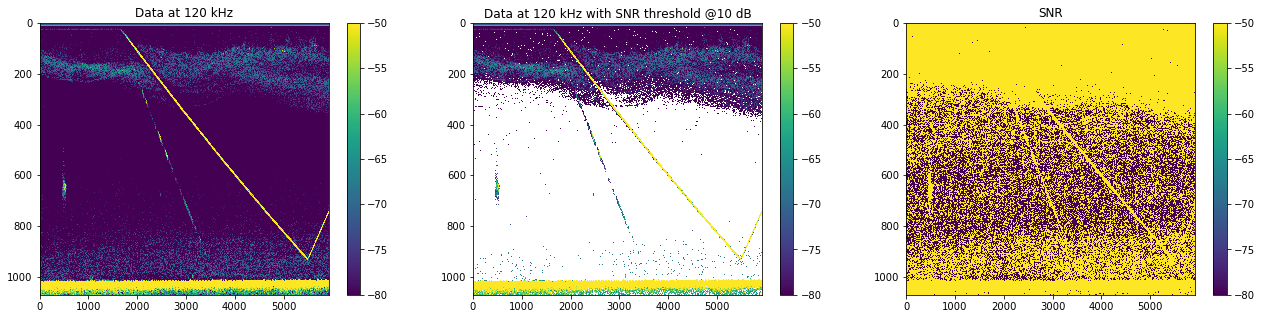

In [100]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(Sv_corr_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Data at 120 kHz')
im1 = ax1.imshow(Sv_corr_120_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im2 = ax2.imshow(Sv_corr_120-Sv_noise_120,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax2)
ax2.set_title('SNR')

## Comparing the above 2 thresholding approach

In [101]:
Sv_th = -79
Sv_corr_120_th = np.copy(Sv_corr_120)
Sv_corr_120_th[Sv_corr_120_th<=Sv_th] = np.nan  # set all values below th to np.nan

### First check how the thresholded data compare:

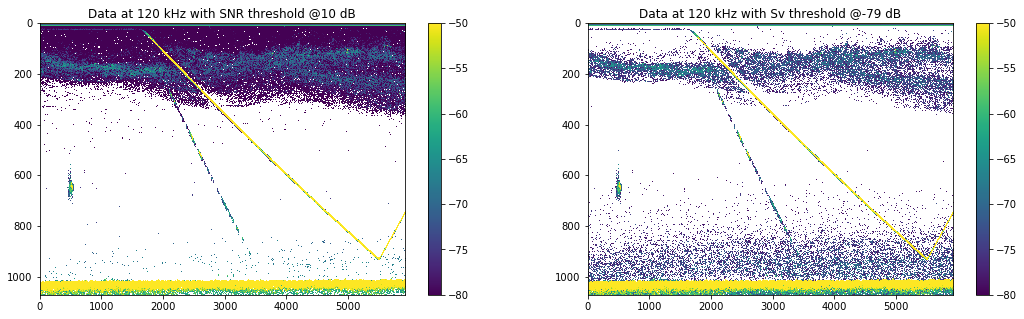

In [111]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(18,5))
im0 = ax0.imshow(Sv_corr_120_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im1 = ax1.imshow(Sv_corr_120_th,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Data at 120 kHz with Sv threshold @%d dB' % Sv_th)

### Now compare how the averaged and threholded data compare:

In [103]:
def mean_MVBS(Sv,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv_cp.shape[0]/N))
    ping_bin_num = int(np.floor(Sv_cp.shape[1]/ping_bin_range))
    MVBS = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N) + N*iD
            ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
            MVBS[iD,iP] = 10*np.log10( np.nanmean(10**(Sv[np.ix_(depth_idx,ping_idx)]/10)) )
            
    return MVBS

In [117]:
Sv_corr_120_SNR_mean = mean_MVBS(Sv_corr_120_SNR,bin_size2,ping_bin_range=20,depth_bin_range=2)
Sv_corr_120_th_mean = mean_MVBS(Sv_corr_120_th,bin_size2,ping_bin_range=20,depth_bin_range=2)

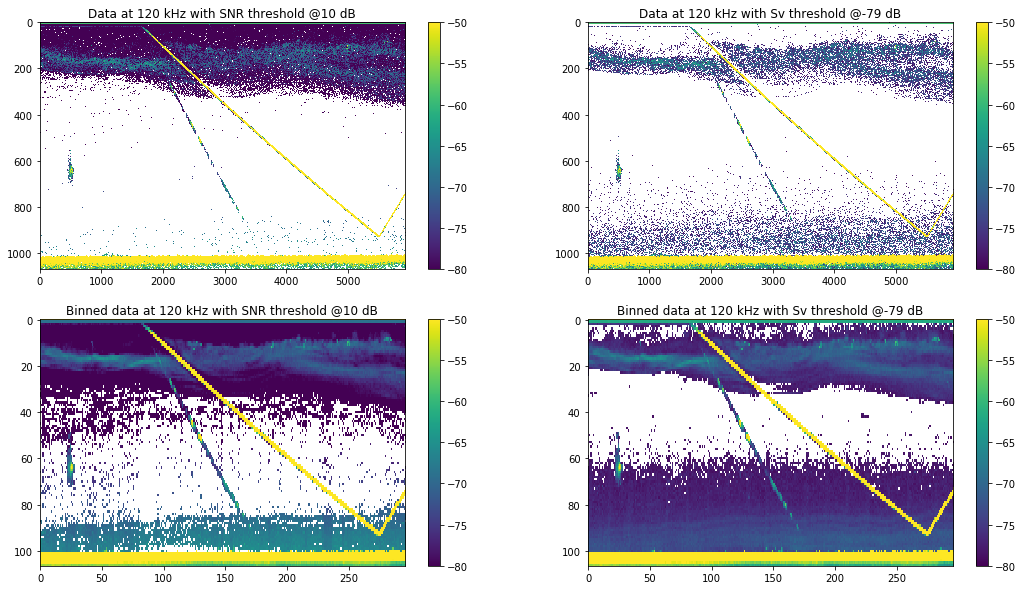

In [118]:
fig,ax = plt.subplots(2,2,figsize=(18,10))
im0 = ax[0,0].imshow(Sv_corr_120_SNR,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im1 = ax[0,1].imshow(Sv_corr_120_th,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Data at 120 kHz with Sv threshold @%d dB' % Sv_th)
im2 = ax[1,0].imshow(Sv_corr_120_SNR_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Binned data at 120 kHz with SNR threshold @%d dB' % SNR_th)
im3 = ax[1,1].imshow(Sv_corr_120_th_mean,aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Binned data at 120 kHz with Sv threshold @%d dB' % Sv_th)